In [1]:
import sys
# custom path insertion
sys.path.insert(1, '..')
sys.path.insert(2, './utils/utils')
sys.path.insert(3, './utils/parameters_hooks')
sys.path.insert(4, '.')
from utils import *

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import yaml

[2024-07-14 17:38:56,005] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/opt/anaconda/anaconda3/envs/elias/compiler_compat/ld: /tmp/tmpqy0209pa/test.o: in function `main':
/tmp/tmpqy0209pa/test.c:1: undefined reference to `io_pgetevents'
collect2: error: ld returned 1 exit status


 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectures
 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


In [20]:
# Load the config file
def load_yaml_config(path):
    with open(path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config_path = '/home/MinnieMouse/project/epmem_edit/configs/gpt2-small_experiment1_1.yml'
config = load_yaml_config(config_path)

# EXTRACTION_CONFIG = config['EXTRACTION_CONFIG']

# Load the pickle file (replace 'your_data_file.pkl' with the path to your pickle file)
pickle_file_path = os.path.join("..",config["EXPERIMENT_CONFIG"]["output_full_path"])

with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

print(data[0].keys())
print(data[0]['activations']['avg'].shape)


dict_keys(['fact_id', 'class_id', 'activations', 'gradients', 'activations_norm', 'gradients_norm', 'activations_hist_norm', 'gradients_hist_norm'])
(48,)


In [9]:
layers_name = ["ATTN 1", "ATTN 2", "MLP 1", "MLP 2"]

In [32]:
TYPE = 'norm'
TRANSFORMATION = 'avg'

## ANALYSIS

### Average activations
It seems that there is a clear distinction in the mean average activations between coherent facts and counterfacts. Furthemore, the standard deviation of counterfacts is greater.

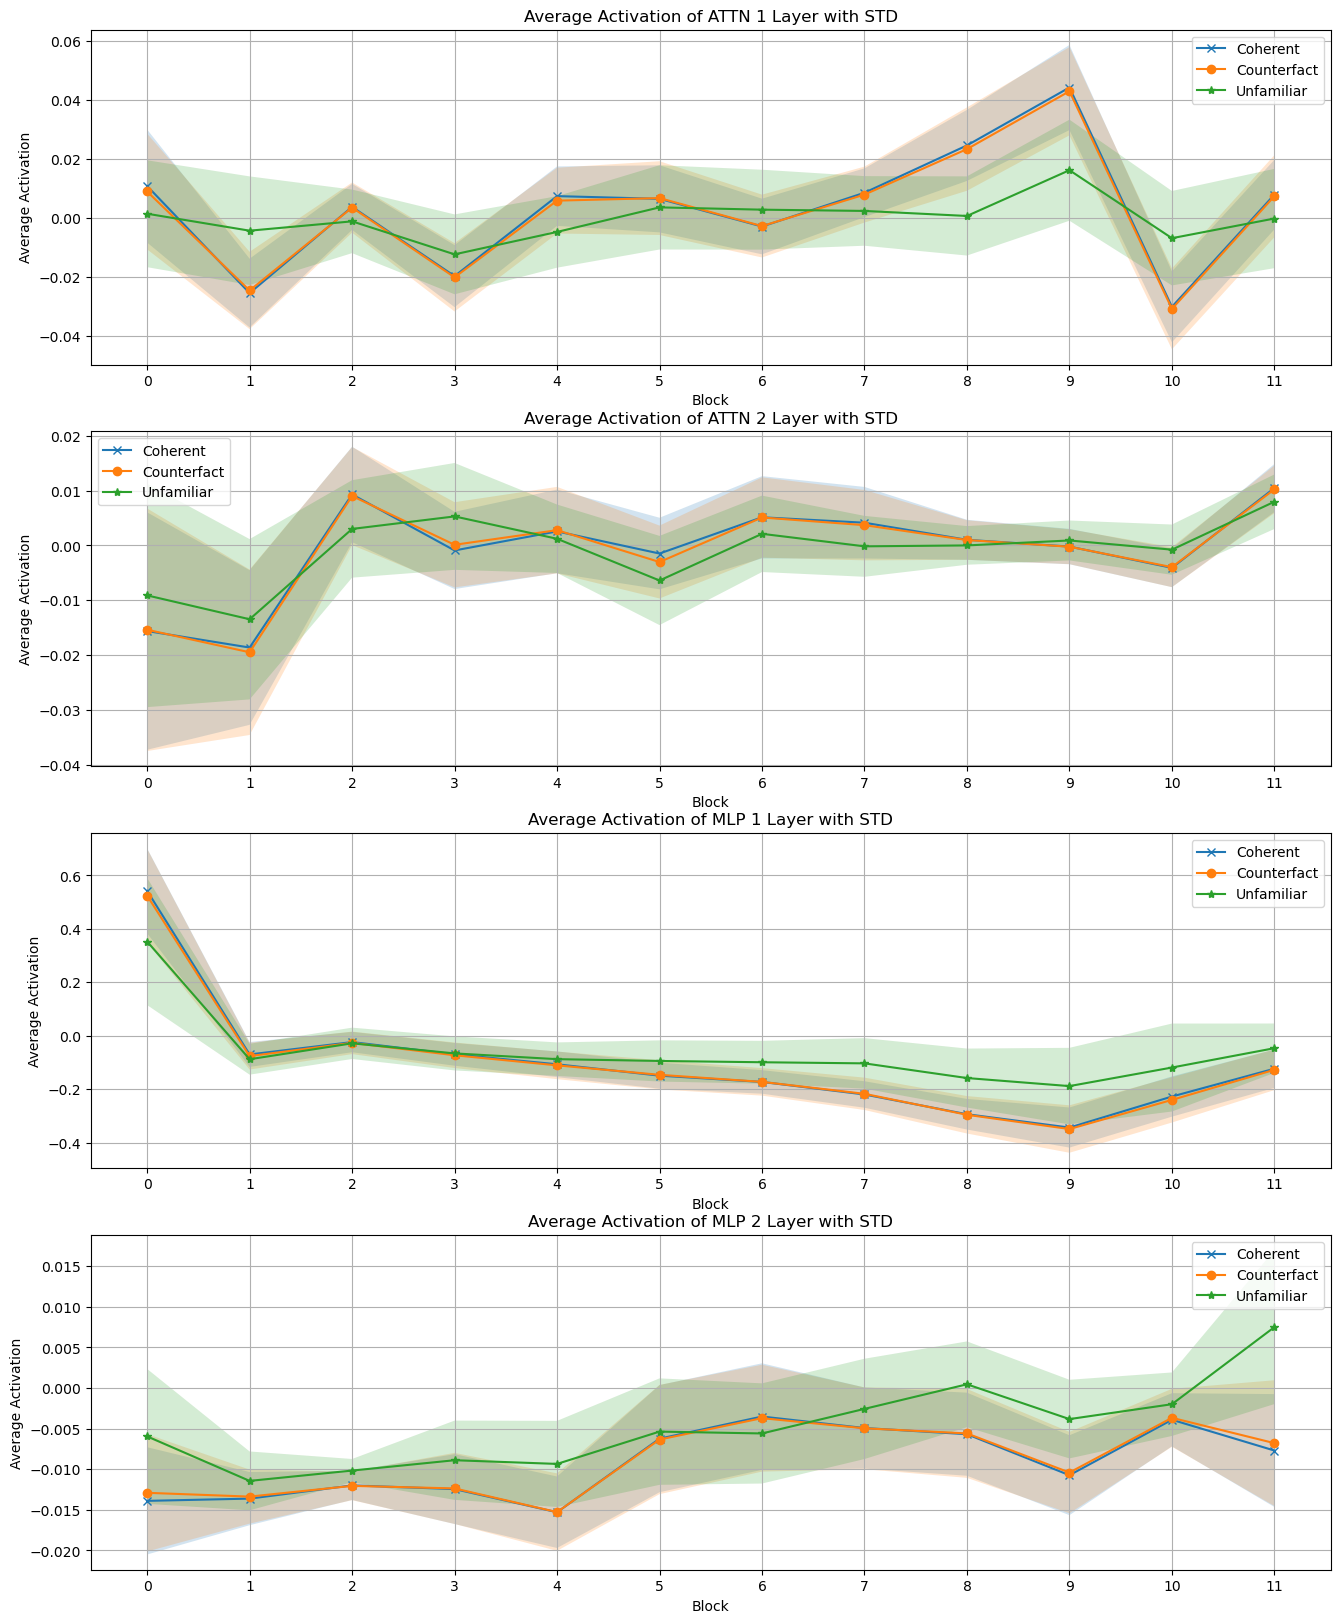

In [33]:
if TYPE is not None:
    key = f"activations_{TYPE}"
else:
    key = f"activations"

# Assuming avg_activations_0, avg_activations_1, avg_activations_2, and n_features are defined
# For demonstration, these should be replaced with your actual data

# Create a figure and a set of subplots
fig_1, axs_1 = plt.subplots(len(layers_name),1,figsize=(16, 5*len(layers_name)))  # 1 row, 2 columns, and optional figure size
fig_2, axs_2 = plt.subplots(len(layers_name),1,figsize=(16, 5*len(layers_name)))  # 1 row, 2 columns, and optional figure size

n_layers = len(layers_name)
n_blocks = int(len(data[0][key][TRANSFORMATION])/n_layers)
for i,layer in enumerate(layers_name):

    activations_0 = [d[key][TRANSFORMATION][i*n_blocks:(i+1)*n_blocks] for d in data if d['class_id'] == 0]
    activations_1 = [d[key][TRANSFORMATION][i*n_blocks:(i+1)*n_blocks] for d in data if d['class_id'] == 1]
    activations_2 = [d[key][TRANSFORMATION][i*n_blocks:(i+1)*n_blocks] for d in data if d['class_id'] == 2]
    
    n_features= len(activations_0[0])


    # Calculate the average of activations for each label across all entries
    avg_activations_0 = np.mean(activations_0, axis=0)
    avg_activations_1 = np.mean(activations_1, axis=0)
    avg_activations_2 = np.mean(activations_2, axis=0)

    std_dev_activations_0 = np.std(activations_0, axis=0)
    std_dev_activations_1 = np.std(activations_1, axis=0)
    std_dev_activations_2 = np.std(activations_2, axis=0)

    # Plot on the first subplot
    axs_1[i].plot(avg_activations_0, label='Coherent', marker='o')
    axs_1[i].plot(avg_activations_1, label='Counterfact', marker='x')
    axs_1[i].plot(avg_activations_2, label='Unfamiliar', marker='*')
    axs_1[i].set_xlabel('Block')
    axs_1[i].set_ylabel('Average Activation')
    axs_1[i].set_title(f'Average Activation of {layer} Layer')
    axs_1[i].set_xticks(np.arange(n_features))  # Ensure x-axis labels match the index of elements
    axs_1[i].legend()
    axs_1[i].grid(True)



    # Plot on the first subplot for the first half of features
    axs_2[i].plot(avg_activations_0, label='Coherent', marker='x')
    axs_2[i].fill_between(range(n_features), avg_activations_0 - std_dev_activations_0, avg_activations_0 + std_dev_activations_0, alpha=0.2)

    axs_2[i].plot(avg_activations_1, label='Counterfact', marker='o')
    axs_2[i].fill_between(range(n_features), avg_activations_1 - std_dev_activations_1, avg_activations_1 + std_dev_activations_1, alpha=0.2)

    axs_2[i].plot(avg_activations_2, label='Unfamiliar', marker='*')
    axs_2[i].fill_between(range(n_features), avg_activations_2 - std_dev_activations_2, avg_activations_2 + std_dev_activations_2, alpha=0.2)

    axs_2[i].set_xlabel('Block')
    axs_2[i].set_ylabel('Average Activation')
    axs_2[i].set_title(f'Average Activation of {layer} Layer with STD')
    axs_2[i].set_xticks(np.arange(n_features))
    axs_2[i].legend()
    axs_2[i].grid(True)

# Show the plots
#plt.tight_layout()  # Adjust the layout to make room for all subplot elements
plt.show()


### Average gradients
No clear differences visible

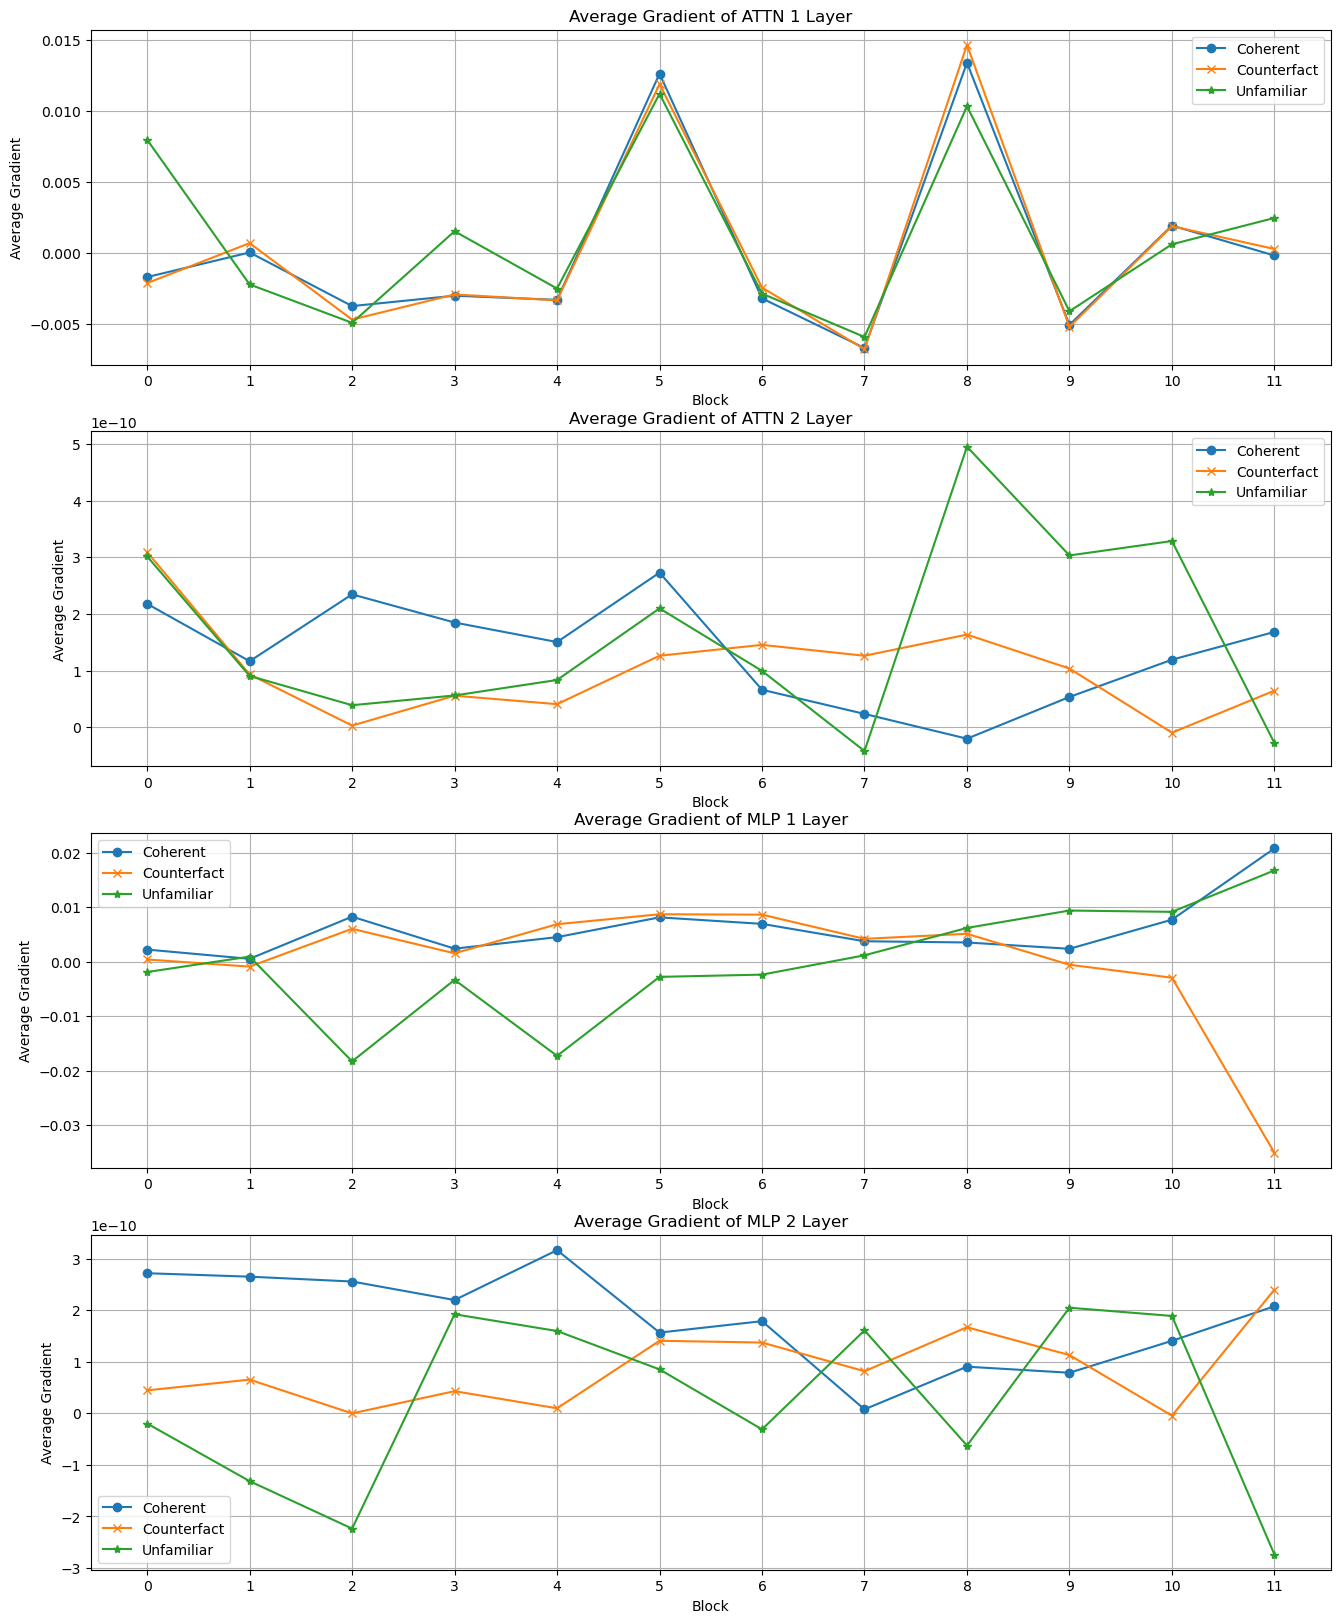

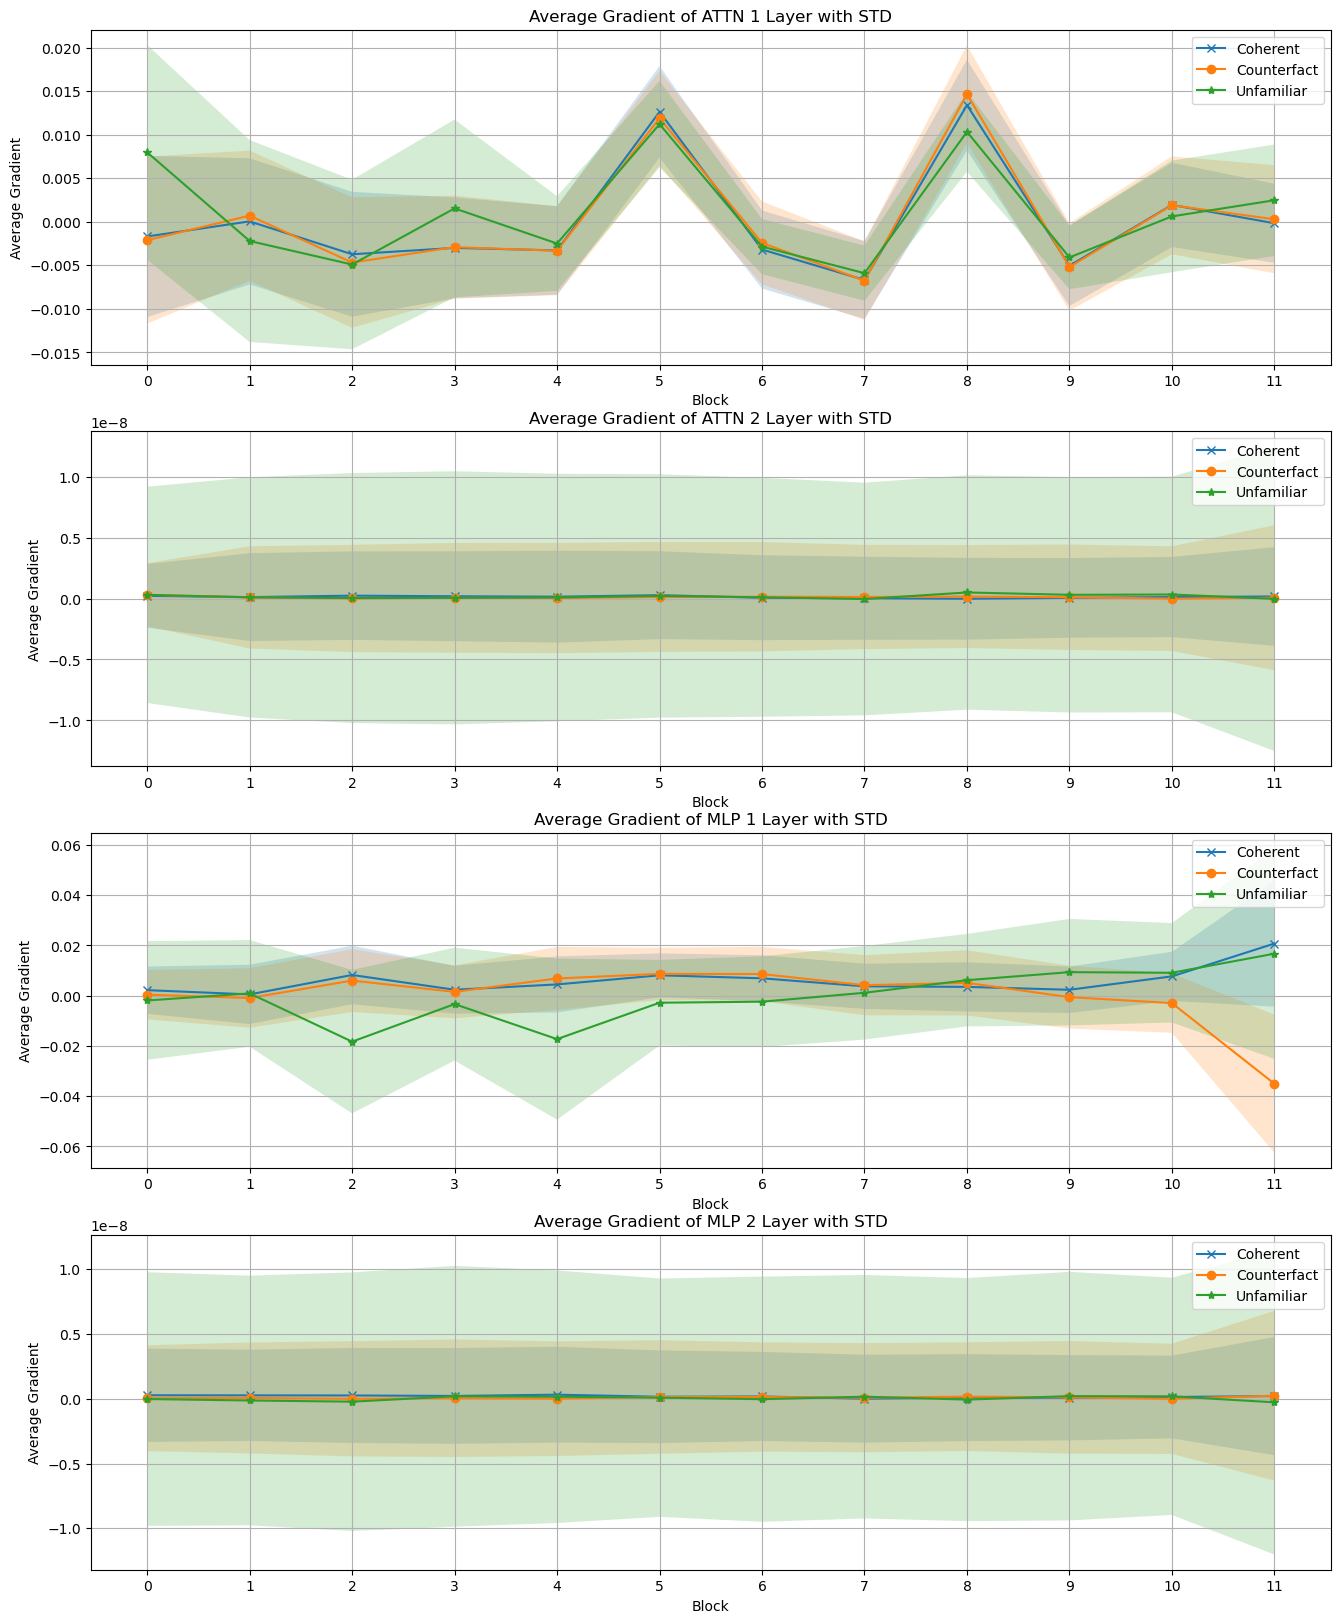

In [34]:
if TYPE is not None:
    key = f"gradients_{TYPE}"
else:
    key = f"gradients"
    
# Create a figure and a set of subplots
fig_1, axs_1 = plt.subplots(len(layers_name),1,figsize=(16, 5*len(layers_name)))  # 1 row, 2 columns, and optional figure size
fig_2, axs_2 = plt.subplots(len(layers_name),1,figsize=(16, 5*len(layers_name)))  # 1 row, 2 columns, and optional figure size

n_layers = len(layers_name)
n_blocks = int(len(data[0][key][TRANSFORMATION])/n_layers)

for i, layer in enumerate(layers_name):

    gradients_0 = [d[key][TRANSFORMATION][i*n_blocks:(i+1)*n_blocks] for d in data if d['class_id'] == 0]
    gradients_1 = [d[key][TRANSFORMATION][i*n_blocks:(i+1)*n_blocks] for d in data if d['class_id'] == 1]
    gradients_2 = [d[key][TRANSFORMATION][i*n_blocks:(i+1)*n_blocks] for d in data if d['class_id'] == 2]

    n_features = len(gradients_0[0])


    # Calculate the average of gradients for each label across all entries
    avg_gradients_0 = np.mean(gradients_0, axis=0)
    avg_gradients_1 = np.mean(gradients_1, axis=0)
    avg_gradients_2 = np.mean(gradients_2, axis=0)

    std_dev_gradients_0 = np.std(gradients_0, axis=0)
    std_dev_gradients_1 = np.std(gradients_1, axis=0)
    std_dev_gradients_2 = np.std(gradients_2, axis=0)

    # Plot on the first subplot
    axs_1[i].plot(avg_gradients_0, label='Coherent', marker='o')
    axs_1[i].plot(avg_gradients_1, label='Counterfact', marker='x')
    axs_1[i].plot(avg_gradients_2, label='Unfamiliar', marker='*')
    axs_1[i].set_xlabel('Block')
    axs_1[i].set_ylabel('Average Gradient')
    axs_1[i].set_title(f'Average Gradient of {layer} Layer')
    axs_1[i].set_xticks(np.arange(n_features))  # Ensure x-axis labels match the index of elements
    axs_1[i].legend()
    axs_1[i].grid(True)



    # Plot on the first subplot for the first half of features
    axs_2[i].plot(avg_gradients_0, label='Coherent', marker='x')
    axs_2[i].fill_between(range(n_features), avg_gradients_0 - std_dev_gradients_0, avg_gradients_0 + std_dev_gradients_0, alpha=0.2)

    axs_2[i].plot(avg_gradients_1, label='Counterfact', marker='o')
    axs_2[i].fill_between(range(n_features), avg_gradients_1 - std_dev_gradients_1, avg_gradients_1 + std_dev_gradients_1, alpha=0.2)

    axs_2[i].plot(avg_gradients_2, label='Unfamiliar', marker='*')
    axs_2[i].fill_between(range(n_features), avg_gradients_2 - std_dev_gradients_2, avg_gradients_2 + std_dev_gradients_2, alpha=0.2)

    axs_2[i].set_xlabel('Block')
    axs_2[i].set_ylabel('Average Gradient')
    axs_2[i].set_title(f'Average Gradient of {layer} Layer with STD')
    axs_2[i].set_xticks(np.arange(n_features))
    axs_2[i].legend()
    axs_2[i].grid(True)

# Show the plots
plt.show()


In [17]:
# Load the pickle file (replace 'your_data_file.pkl' with the path to your pickle file)
pickle_file_path = os.path.join("..",config["EXPERIMENT_CONFIG"]["output_full_path"])

with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)
print(data[0])

act_coherent = data["coherent_act"]
act_counterfact = data["counterfact_act"]
act_unfamiliar = data["unfamiliar_act"]

grad_coherent = data["coherent_grad"]
grad_counterfact = data["counterfact_grad"]
grad_unfamiliar = data["unfamiliar_grad"]

{'fact_id': '0T', 'class_id': 0, 'activations': {'avg': array([[-9.36798751e-03,  1.77761614e-02, -1.50296437e-02,
         7.74326595e-03, -3.82323787e-02, -3.48469950e-02,
         2.89755668e-02, -1.20577477e-02,  9.84989572e-03,
        -1.44216521e-02,  5.65514378e-02, -6.84876926e-03],
       [ 6.07588142e-03,  2.46965736e-02, -7.39018479e-03,
         9.68824979e-03,  5.92341507e-03,  3.58579564e-03,
         2.95097620e-04, -3.11197783e-03, -7.32396031e-03,
         1.19169159e-02, -4.36122306e-02, -6.49054348e-01],
       [-2.00178933e+00, -6.74998760e-01, -1.18820417e+00,
        -1.33208692e+00, -1.03118086e+00, -1.13640344e+00,
        -1.05376923e+00, -1.06540430e+00, -1.06426668e+00,
        -1.07059252e+00, -1.13630950e+00, -1.60146272e+00],
       [-1.49125755e-02, -2.16698404e-02,  8.70129988e-02,
         9.51305870e-03, -8.20276607e-03, -1.29995272e-02,
        -1.67239904e-02,  1.12051219e-02, -1.51245473e-02,
         3.83907631e-02,  7.11770728e-02, -2.83925533e-0

TypeError: list indices must be integers or slices, not str

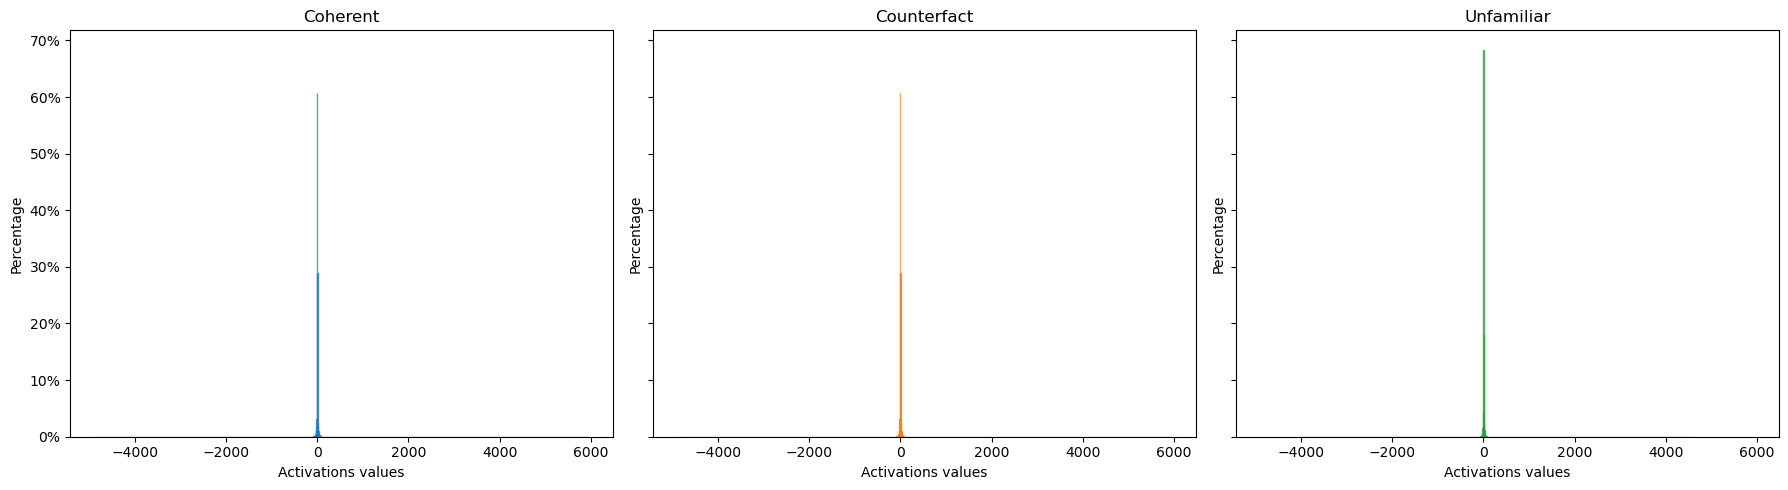

In [22]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)  # 1 row, 3 columns

# Calculate weights for each vector to convert histogram counts to percentages
weights_a = np.ones_like(act_coherent) / len(act_coherent)
weights_b = np.ones_like(act_counterfact) / len(act_counterfact)
weights_c = np.ones_like(act_unfamiliar) / len(act_unfamiliar)

# Plot histograms for each vector
axs[0].hist(act_coherent, bins=1000, weights=weights_a, alpha=0.7, edgecolor='tab:blue')
axs[0].set_title('Coherent')
axs[0].yaxis.set_major_formatter(PercentFormatter(1))

axs[1].hist(act_counterfact, bins=1000, weights=weights_b, alpha=0.7, edgecolor='tab:orange')
axs[1].set_title('Counterfact')
axs[1].yaxis.set_major_formatter(PercentFormatter(1))

axs[2].hist(act_unfamiliar, bins=1000, weights=weights_c, alpha=0.7, edgecolor='tab:green')
axs[2].set_title('Unfamiliar')
axs[2].yaxis.set_major_formatter(PercentFormatter(1))

# Set common labels
for ax in axs:
    ax.set_xlabel('Activations values')
    ax.set_ylabel('Percentage')

plt.tight_layout()
plt.show()

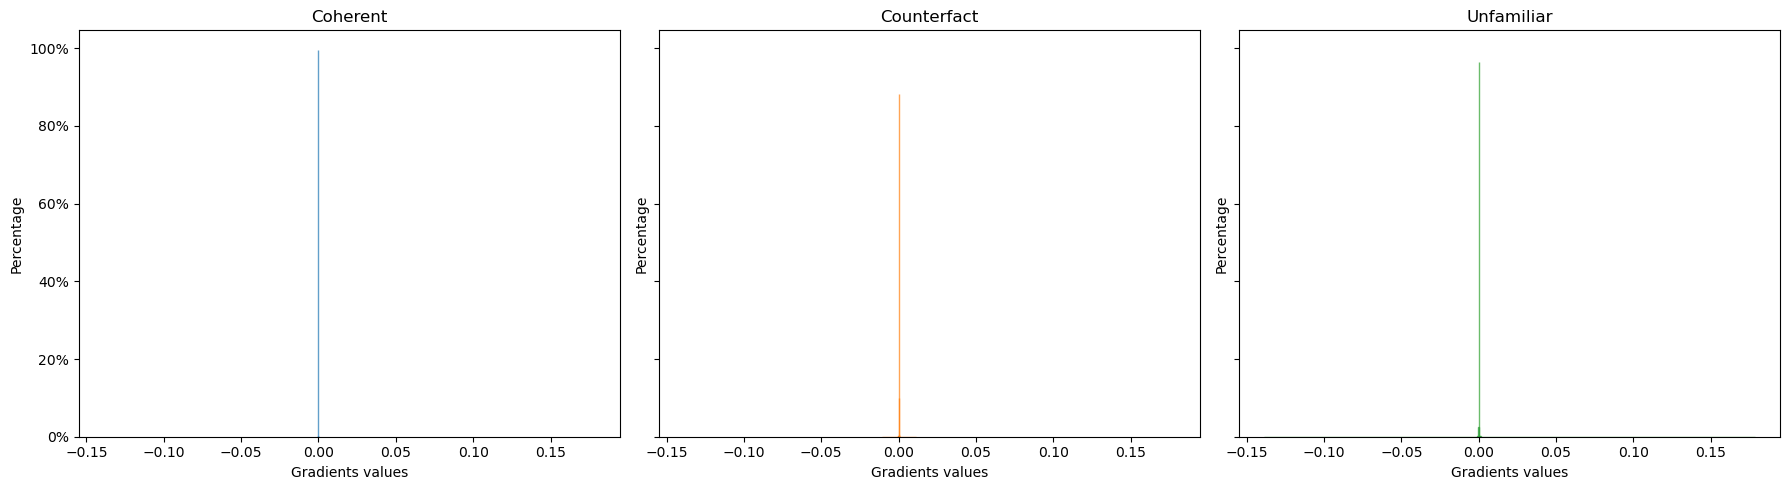

In [23]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)  # 1 row, 3 columns

# Calculate weights for each vector to convert histogram counts to percentages
weights_a = np.ones_like(grad_coherent) / len(grad_coherent)
weights_b = np.ones_like(grad_counterfact) / len(grad_counterfact)
weights_c = np.ones_like(grad_unfamiliar) / len(grad_unfamiliar)

# Plot histograms for each vector
axs[0].hist(grad_coherent, bins=1000, weights=weights_a, alpha=0.7, edgecolor='tab:blue')
axs[0].set_title('Coherent')
axs[0].yaxis.set_major_formatter(PercentFormatter(1))

axs[1].hist(grad_counterfact, bins=1000, weights=weights_b, alpha=0.7, edgecolor='tab:orange')
axs[1].set_title('Counterfact')
axs[1].yaxis.set_major_formatter(PercentFormatter(1))

axs[2].hist(grad_unfamiliar, bins=1000, weights=weights_c, alpha=0.7, edgecolor='tab:green')
axs[2].set_title('Unfamiliar')
axs[2].yaxis.set_major_formatter(PercentFormatter(1))

# Set common labels
for ax in axs:
    ax.set_xlabel('Gradients values')
    ax.set_ylabel('Percentage')

plt.tight_layout()
plt.show()